# MISA Lab 3

## Students: Leonardo Pestana Legori, Lisle Faray de Paiva

## Register atlases

In [5]:
import glob

path_test_images = '..\\test-set\\testing-images\\*'
filenames_images = [file for file in glob.glob(path_test_images)]

elastix = "..\\elastix-5.0.0-win64\\elastix.exe"
elastix = "..\\elastix_windows32_v4.2\\elastix.exe"
mov = "..\\mira_results\\atlas_intensities.nii.gz"
mov = "..\\MNITemplateAtlas\\template.nii.gz"
par1 = "..\\Par0010\\par0010affine.txt"
par2 = "..\\Par0010\\par0010bspline.txt"
out_path_elastix = "..\\output"

registration_results_path = "..\\registration_results"

# transformix
transformix = "..\\elastix-5.0.0-win64\\transformix.exe"
transformix = "..\\elastix_windows32_v4.2\\transformix.exe"
parameters = out_path_elastix + "\\TransformParameters.1.txt"
out_path_transformix = "..\\output2"

In [4]:
import os

for file in filenames_images:
    number_case = file.split('\\')[-1].split('.')[0]
    !{elastix} -f {file} -m {mov} -p {par1} -p {par2} -out {out_path_elastix}
    
    # if output doesn't exist then break the loop
    if not os.path.exists(out_path_elastix + "\\result.1.nii.gz"):
        print("Output doesn't exist for case: ", number_case)
        break

    # move the result image to the registration_results folder
    !mv {out_path_elastix + "\\result.1.nii.gz"} {registration_results_path + "\\atlas_" + number_case + "_intensities.nii.gz"}

    # replace (ResultImagePixelType "short") with (ResultImagePixelType "float") using sed
    !sed -i 's/(ResultImagePixelType "short")/(ResultImagePixelType "float")/g' {parameters}

    # replace (FinalBSplineInterpolationOrder 3) with (FinalBSplineInterpolationOrder 0) using sed
    !sed -i 's/(FinalBSplineInterpolationOrder 3)/(FinalBSplineInterpolationOrder 0)/g' {parameters}

    for tissue in ['bg', 'csf', 'gm', 'wm']:
        in_img = "..\\mira_results\\atlas_" + tissue + ".nii.gz"
        in_img = "..\\MNITemplateAtlas\\atlas_" + tissue + ".nii.gz"
        !{transformix} -in {in_img} -out {out_path_transformix} -tp {parameters}

        !mv {out_path_transformix + "\\result.nii.gz"} {registration_results_path + "\\atlas_" + number_case + "_label_" + tissue + ".nii.gz"}


elastix is started at Mon Nov 06 21:48:15 2023.

-------------------------------------------------------------------------

Running elastix with parameter file 0: "..\Par0010\par0010affine.txt".

Current time: Mon Nov 06 21:48:15 2023.
Reading the elastix parameters from file ...

Installing all components.
InstallingComponents was successful.

ELASTIX version: 4.200
Command line options from ElastixBase:
-f        ..\test-set\testing-images\1018.nii.gz
-m        ..\MNITemplateAtlas\template.nii.gz
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ..\output/
-p        ..\Par0010\par0010affine.txt
-p        ..\Par0010\par0010bspline.txt
-priority unspecified, so NORMAL process priority
-threads  unspecified, so all available threads are used
Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 269 ms.

  A default pyramid schedule is used.
  A default pyrami

In [11]:
import nibabel as nib

mni_atlas = "..\\MNITemplateAtlas\\atlas.nii.gz"

# load 4d atlas
atlas = nib.load(mni_atlas)
atlas_data = atlas.get_fdata()

# save each tissue in a different file: bg, csf, gm, wm
bg = atlas_data[:, :, :, 0]
csf = atlas_data[:, :, :, 1]
gm = atlas_data[:, :, :, 2]
wm = atlas_data[:, :, :, 3]

nib.save(nib.Nifti1Image(bg, atlas.affine, atlas.header), "..\\MNITemplateAtlas\\atlas_bg.nii.gz")
nib.save(nib.Nifti1Image(csf, atlas.affine, atlas.header), "..\\MNITemplateAtlas\\atlas_csf.nii.gz")
nib.save(nib.Nifti1Image(gm, atlas.affine, atlas.header), "..\\MNITemplateAtlas\\atlas_gm.nii.gz")
nib.save(nib.Nifti1Image(wm, atlas.affine, atlas.header), "..\\MNITemplateAtlas\\atlas_wm.nii.gz")

## Imports

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm.auto import trange, tqdm
import dask
from dask.distributed import Client
import time
import glob
import pandas as pd
import seaborn as sns
from scipy.optimize import linear_sum_assignment

## Segmentation with the probabilistic atlas (label propagation)

In [2]:
def process_image_atlas(atlas_labels, tissue_mask, slice_n = 160, plot=False):
    orig_shape = atlas_labels['csf'].shape

    prob_csf_test = atlas_labels['csf'][tissue_mask == 1].reshape(-1, 1)
    prob_wm_test = atlas_labels['wm'][tissue_mask == 1].reshape(-1, 1)
    prob_gm_test = atlas_labels['gm'][tissue_mask == 1].reshape(-1, 1)

    prob_atlas = np.concatenate((prob_csf_test, prob_wm_test, prob_gm_test), axis=1)

    atlas_argmax_res = np.argmax(prob_atlas, axis=1)

    labels_atlas = np.zeros(orig_shape)
    labels_atlas[tissue_mask == 1] = atlas_argmax_res + 1

    if plot:
        fig, axs = plt.subplots(1, 4, figsize=(8, 8))

        axs = axs.flatten()

        axs[0].imshow(labels_atlas[:, :, slice_n], cmap='jet')
        axs[0].set_title('Labeled image')

        axs[1].imshow(labels_atlas[:, :, slice_n] == 1, cmap='gray')
        axs[1].set_title('csf')

        axs[2].imshow(labels_atlas[:, :, slice_n] == 2, cmap='gray')
        axs[2].set_title('wm')

        axs[3].imshow(labels_atlas[:, :, slice_n] == 3, cmap='gray')
        axs[3].set_title('gm')

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

    return labels_atlas, prob_atlas

## Segmentation with tissue models

In [3]:
def process_image_tm(input_img, tissue_mask, tissue_models, scaler, slice_n=160, plot=False):
    orig_shape = input_img.shape

    # reshape to 1D
    input_img_1d = input_img[tissue_mask == 1].reshape(-1, 1)

    input_img_scaled = scaler.transform(input_img_1d).astype(np.uint8)

    # for each intensity value of test_image_scaled (0, 255), get the probability of each tissue
    prob_tissue_models = np.zeros((input_img_scaled.shape[0], 3))

    for i in range(input_img_scaled.shape[0]):
        prob_tissue_models[i, 0] = tissue_models['csf'][input_img_scaled[i][0]]
        prob_tissue_models[i, 1] = tissue_models['wm'][input_img_scaled[i][0]]
        prob_tissue_models[i, 2] = tissue_models['gm'][input_img_scaled[i][0]]

    # get the maximum probability for each voxel
    max_prob = np.argmax(prob_tissue_models, axis=1)

    # reshape to 3D
    labels_tm = np.zeros(orig_shape)
    labels_tm[tissue_mask == 1] = max_prob + 1

    if plot:
        # plot
        fig, axs = plt.subplots(1, 5, figsize=(8, 8))

        axs = axs.flatten()

        axs[0].imshow(input_img[:, :, slice_n], cmap='gray')
        axs[0].set_title('Original Image')

        axs[1].imshow(labels_tm[:, :, slice_n], cmap='jet')
        axs[1].set_title('Labeled image')

        axs[2].imshow(labels_tm[:, :, slice_n] == 1, cmap='gray')
        axs[2].set_title('csf')

        axs[3].imshow(labels_tm[:, :, slice_n] == 2, cmap='gray')
        axs[3].set_title('wm')

        axs[4].imshow(labels_tm[:, :, slice_n] == 3, cmap='gray')
        axs[4].set_title('gm')

        # hide ticks
        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()

    return labels_tm, prob_tissue_models

## EM

In [4]:
from sklearn.cluster import KMeans

# initialization_type: 'kmeans', 'random', 'lp', 'tm', 'lp_and_tm'
# lp: label propagation
# tm: tissue models

# into_or_after: 'none', 'into', 'after'
# into: initialize with label propagation and tissue models soft probabilities, then do EM
# after: do EM, then multiply the result with label propagation and tissue models probabilities

def em_segmentation(img1, img2, tissue_mask, init_type = 'lp_and_tm', into_or_after = 'none', init_atlas_weights = None,
                    init_tm_weights = None, em_atlas_weights = None, n_clusters=3, n_iterations=1000, plot=False, slice_n=160):
    
    orig_shape = img1.shape


    # get the data points of the tissue mask in a 1D array
    if img2 is not None:
        data1 = img1[tissue_mask == 1].reshape(-1, 1)
        data2 = img2[tissue_mask == 1].reshape(-1, 1)
        X = np.concatenate((data1, data2), axis=1)
    else:
        X = img1[tissue_mask == 1].reshape(-1, 1)
 
    # initialize centroids

    centroids = None
    init_weights = None
    if init_type == 'kmeans':
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
        K_means_cluster_labels = kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_
    elif init_type == 'random': # randomly select n_clusters points from X as initial centroids
        centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False), :]

    elif init_type == 'lp':
        init_weights = init_atlas_weights
    elif init_type == 'tm':
        init_weights = init_tm_weights  
    elif init_type == 'lp_and_tm':
        init_weights = init_atlas_weights * init_tm_weights


    # initialize clusters parameters

    if init_weights is not None:
        init_labels = np.argmax(init_weights, axis=1)
        # maximization
        nk = np.sum(init_weights, axis=0)

    clusters = []
    for i in range(n_clusters):
        clusters.append({})

        if init_type == 'kmeans':
            clusters[i]['mu'] = centroids[i] # mean
            clusters[i]['cov'] = np.cov(X[K_means_cluster_labels == i].T) # covariance
            clusters[i]['alpha'] = np.sum(K_means_cluster_labels == i) / X.shape[0] # mixture weight

        elif init_type == 'random':
            clusters[i]['mu'] = centroids[i] # mean
            clusters[i]['cov'] = np.cov(X.T) # covariance
            clusters[i]['alpha'] = 1 / n_clusters # mixture weight

        elif init_weights is not None: # do a maximization step since we have soft probabilities
            clusters[i]['alpha'] = nk[i] / np.sum(nk)
            clusters[i]['mu'] = np.sum(init_weights[:, i].reshape(-1, 1) * X, axis=0) / nk[i]
            mu = np.tile(clusters[i]['mu'], (X.shape[0], 1))
            r = X - mu
            clusters[i]['cov'] = ((init_weights[:, i].reshape(-1, 1) * r).T @ r) / nk[i]
            

    ## EM algorithm

    log_per_iteration = []
    iter_n_final = 0
    for iterations in range(n_iterations):
        
        # expectation
        gm = np.zeros((X.shape[0], n_clusters))
        for i in range(n_clusters):
            clusters[i]['cov'] = np.maximum(clusters[i]['cov'], np.eye(X.shape[1]) * 1e-10) # avoid singular matrix
            q = 1 / np.sqrt((2 * np.pi) ** X.shape[1] * np.linalg.det(clusters[i]['cov']))
            mu = np.tile(clusters[i]['mu'], (X.shape[0], 1))
            r = X - mu
            # print(np.linalg.det(clusters[i]['cov']))
            icov = np.linalg.pinv(clusters[i]['cov'])
            e = np.sum((r @ icov) * r, axis=1)
            gm[:, i] = q * np.exp(-0.5 * e)

        alpha_times_gm = np.array([clusters[i]['alpha'] for i in range(n_clusters)]) * gm
        
        membership_weight = (alpha_times_gm * gm) / \
            np.sum(alpha_times_gm * gm, axis=1, keepdims=True)
        
        if into_or_after == 'into':
            membership_weight = membership_weight * em_atlas_weights


        log_per_iteration.append(np.sum(np.log(np.sum(alpha_times_gm * gm, axis=1))))

        # check convergence (adjust threshold as needed)
        if iterations > 0:
            if np.abs(log_per_iteration[-1] - log_per_iteration[-2]) < 1e-3:
                print(f'Converged after {iterations} iterations')
                break


        # maximization
        nk = np.sum(membership_weight, axis=0)
        for i in range(n_clusters):
            clusters[i]['alpha'] = nk[i] / np.sum(nk)
            clusters[i]['mu'] = np.sum(membership_weight[:, i].reshape(-1, 1) * X, axis=0) / nk[i]
            mu = np.tile(clusters[i]['mu'], (X.shape[0], 1))
            r = X - mu
            clusters[i]['cov'] = ((membership_weight[:, i].reshape(-1, 1) * r).T @ r) / nk[i]


        iter_n_final += 1

    if into_or_after == 'after':
            membership_weight = membership_weight * em_atlas_weights


    ## get the labels

    em_labels = np.argmax(membership_weight, axis=1) # get the corresponding label
    labels_full = np.zeros(orig_shape)
    labels_full[tissue_mask == 1] = em_labels + 1 # add one to avoid zero label for background


    ## plot if requested

    if plot:
        fig, axs = plt.subplots(1, 4, figsize=(12, 4))

        axs = axs.flatten()

        if img2 is not None:
            # plot data
            axs[0].scatter(X[:, 0], X[:, 1], s=10)
            axs[0].set_title('Original data')

            if init_type == 'kmeans':
                # plot K-means result
                axs[1].scatter(X[:, 0], X[:, 1], c=K_means_cluster_labels, s=10)
                axs[1].set_title('K-means result')
            elif init_type == 'random':
                # plot random initialization points
                axs[1].scatter(X[:, 0], X[:, 1], c='gray', s=20)
                axs[1].scatter(centroids[:, 0], centroids[:, 1], c='red', s=30)
                axs[1].set_title('Random initialization')

            # plot EM result
            axs[2].scatter(X[:, 0], X[:, 1], c=em_labels, s=10)
            axs[2].set_title('EM result')
        else:
            # plot data
            axs[0].hist(X, bins=100, color='gray')
            # axs[0].scatter(X, range(X.shape[0]), s=10)
            axs[0].set_title('Original data')
            axs[0].set_yticks([])

            hist_colors = ['r', 'g', 'b']

            if init_type == 'kmeans':
                # plot K-means result, using kmeans result as weights for histogram
                axs[1].hist(X, bins=100, color='gray')
                for i in range(n_clusters):
                    axs[1].hist(X, bins=100, density=False, weights=(K_means_cluster_labels == i).astype(int), histtype='step', color=hist_colors[i])
                # axs[1].scatter(X, range(X.shape[0]), c=K_means_cluster_labels, s=10)
                axs[1].set_title('K-means result')
                axs[1].set_yticks([])
            elif init_type == 'random':
                # plot random initialization points as red vertical lines
                axs[1].hist(X, bins=100, color='gray')
                for i in range(n_clusters):
                    axs[1].axvline(x=centroids[i], c='red')

                # axs[1].scatter(X, range(X.shape[0]), s=10)
                axs[1].set_title('Random initialization')
                axs[1].set_yticks([])
            elif init_weights is not None:
                # plot K-means result, using kmeans result as weights for histogram
                axs[1].hist(X, bins=100, color='gray')
                for i in range(n_clusters):
                    axs[1].hist(X, bins=100, density=False, weights=(init_labels == i).astype(int), histtype='step', color=hist_colors[i])
                # axs[1].scatter(X, range(X.shape[0]), c=K_means_cluster_labels, s=10)
                axs[1].set_title(f'{init_type} initialization')
                axs[1].set_yticks([])

            # plot EM result with histogram, display mixture components as lines that follow the histogram shape
            axs[2].hist(X, bins=100, color='gray')
            for i in range(n_clusters):
                axs[2].hist(X, bins=100, density=False, weights=(em_labels == i).astype(int), histtype='step', color=hist_colors[i])
            axs[2].set_title('EM result')
            axs[2].set_yticks([])

        # plot log-likelihood over iterations
        axs[3].plot(log_per_iteration)
        axs[3].set_title('Log-likelihood')

        plt.tight_layout()
        plt.show()

        fig, axs = plt.subplots(1, 4, figsize=(8, 8))

        axs = axs.flatten()

        axs[0].imshow(labels_full[:, :, slice_n], cmap='jet')
        axs[0].set_title('Labeled image')

        axs[1].imshow(labels_full[:, :, slice_n] == 1, cmap='gray')
        axs[1].set_title('Label 1')

        axs[2].imshow(labels_full[:, :, slice_n] == 2, cmap='gray')
        axs[2].set_title('Label 2')

        axs[3].imshow(labels_full[:, :, slice_n] == 3, cmap='gray')
        axs[3].set_title('Label 3')

        # hide ticks
        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

    return labels_full, iter_n_final

In [5]:
def reorder_labels(labels_em, labels_gt, plot=True, slice_n=160):

    # attention, please check what are the actual label values for the dataset you are working with
    csf_label_num = 1
    wm_label_num = 2
    gm_label_num = 3

    label_csf = labels_gt == csf_label_num
    label_wm = labels_gt == wm_label_num
    label_gm = labels_gt == gm_label_num

    # dice score for each cluster and each tissue type
    dice_score = np.zeros((3, 3))

    for cluster in range(3):
        label_cluster = (labels_em == cluster + 1)
        dice_score[cluster, (csf_label_num-1)] = np.sum(label_csf[label_cluster]) * 2.0 / (np.sum(label_csf) + np.sum(label_cluster))
        dice_score[cluster, (wm_label_num-1)] = np.sum(label_wm[label_cluster]) * 2.0 / (np.sum(label_wm) + np.sum(label_cluster))
        dice_score[cluster, (gm_label_num-1)] = np.sum(label_gm[label_cluster]) * 2.0 / (np.sum(label_gm) + np.sum(label_cluster))

    # re-order the label array according to the dice score
    # CSF is label 1, GM is label 3, and WM is label 2
    labels_em_reordered = np.zeros(labels_em.shape)
    # use the linear_sum_assignment function to find the optimal assignment of clusters to tissue types
    # note that we need to negate the dice score matrix since the function minimizes the cost
    cluster_idx, tissue_idx = linear_sum_assignment(-dice_score)
    # map the clusters to the tissue types using the indices
    cluster_to_tissue = dict(zip(cluster_idx+1, tissue_idx+1))
    for i in range(3):
        #print(cluster_to_tissue[i+1])
        labels_em_reordered[labels_em == i+1] = cluster_to_tissue[i+1]

    if plot:
        # plot the label array, show 3 side legends for each value
        plt.figure(figsize=(4,4))
        plt.imshow(labels_em_reordered[:, :, slice_n], cmap='jet')
        plt.title('Labeled image')
        # create a list of labels for each value
        labels = ['Background', 'CSF', 'WM', 'GM']
        # create a list of patches for each color
        patches = [plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=plt.cm.jet(i/3), 
                label="{:s}".format(labels[i]) )[0]  for i in range(0, 4)]
        # put the legend outside the plot, with 1 column
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
        plt.show()

    # get final ordered dice score for each tissue type
    dice_score_reordered = {}
    dice_score_reordered['csf'] = np.max(dice_score[(csf_label_num-1), :])
    dice_score_reordered['wm'] = np.max(dice_score[(wm_label_num-1), :])
    dice_score_reordered['gm'] = np.max(dice_score[(gm_label_num-1), :])

    # print dice score
    print('Dice scores:')
    for key, value in dice_score_reordered.items():
        print(f'{key}: {value}')

    return labels_em_reordered, dice_score_reordered

In [121]:
def plot_res(slice_n, label_em, label_gt):
    fig, axs = plt.subplots(2, 3, figsize=(6, 5))

    axs[0, 0].imshow(label_em[:, :, slice_n] == 1, cmap='gray')
    axs[0, 0].set_title(f'EM CSF')

    axs[0, 1].imshow(label_em[:, :, slice_n] == 2, cmap='gray')
    axs[0, 1].set_title('EM GM')

    axs[0, 2].imshow(label_em[:, :, slice_n] == 3, cmap='gray')
    axs[0, 2].set_title('EM WM')

    # plot ground truth
    axs[1, 0].imshow(label_gt[:, :, slice_n] == 1, cmap='gray')
    axs[1, 0].set_title('Ground Truth CSF')

    axs[1, 1].imshow(label_gt[:, :, slice_n] == 2, cmap='gray')
    axs[1, 1].set_title('Ground Truth GM')

    axs[1, 2].imshow(label_gt[:, :, slice_n] == 3, cmap='gray')
    axs[1, 2].set_title('Ground Truth WM')

    # hide ticks
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [7]:
def calculate_dice_score(labels_seg, labels_gt, print_score=True):
    dice_score = {}
    
    # please check what are the actual label values for the dataset you are working with

    label_seg_csf = labels_seg == 1
    label_seg_wm = labels_seg == 2
    label_seg_gm = labels_seg == 3

    label_gt_csf = labels_gt == 1
    label_gt_wm = labels_gt == 2
    label_gt_gm = labels_gt == 3

    dice_score['csf'] = np.sum(label_gt_csf[label_seg_csf]) * 2.0 / (np.sum(label_gt_csf) + np.sum(label_seg_csf))
    dice_score['wm'] = np.sum(label_gt_wm[label_seg_wm]) * 2.0 / (np.sum(label_gt_wm) + np.sum(label_seg_wm))
    dice_score['gm'] = np.sum(label_gt_gm[label_seg_gm]) * 2.0 / (np.sum(label_gt_gm) + np.sum(label_seg_gm))

    if print_score:
        print('Dice scores:')
        for key, value in dice_score.items():
            print(f'{key}: {value}')

    return dice_score

In [8]:
@dask.delayed
def perform_em_segmentation(case_number, input_img, tissue_mask, init_type, into_or_after, prob_atlas_mira, prob_atlas_mni, prob_tissue_models, gt, plot=False):

    initial_time = time.time()
    if prob_atlas_mni is None:
        atlas_name = 'mira'
        labels_em, iter_n = em_segmentation(input_img, None, tissue_mask, init_type, into_or_after, init_atlas_weights=prob_atlas_mira,
                                    init_tm_weights=prob_tissue_models, em_atlas_weights=prob_atlas_mira, plot=plot)
    else:
        atlas_name = 'mni'
        labels_em, iter_n = em_segmentation(input_img, None, tissue_mask, init_type, into_or_after, init_atlas_weights=prob_atlas_mira,
                                    init_tm_weights=prob_tissue_models, em_atlas_weights=prob_atlas_mni, plot=plot)
    final_time = time.time()
    elapsed_time = final_time - initial_time
    print(f'Elapsed time: {elapsed_time} seconds')
    labels_em_reordered, dice_score_em = reorder_labels(labels_em, gt, plot=plot)
    
    results = {
        'case_n': case_number,
        'atlas': atlas_name,
        'method': 'em',
        'dice_csf': dice_score_em['csf'],
        'dice_wm': dice_score_em['wm'],
        'dice_gm': dice_score_em['gm'],
        'labels_em': labels_em_reordered,
        'init_type': init_type,
        'into_or_after': into_or_after,
        'elapsed_time': elapsed_time,
        'iter_n': iter_n,
    }
    
    if plot:
        plot_res(160, labels_em_reordered, gt)

    return results

In [9]:
def get_results_case(input_img, case_number, gt, tissue_mask, atlas_label_mira, atlas_label_mni, tissue_models, scaler, slice_n=160, plot=False):

    # atlas MIRA
    labels_atlas_mira, prob_atlas_mira = process_image_atlas(atlas_label_mira, tissue_mask, slice_n=slice_n, plot=plot)
    dice_score_atlas_mira = calculate_dice_score(labels_atlas_mira, gt, print_score=plot)

    results_lp_mira = {
        'case_n': case_number,
        'atlas': 'mira',
        'method': 'lp',
        'dice_csf': dice_score_atlas_mira['csf'],
        'dice_wm': dice_score_atlas_mira['wm'],
        'dice_gm': dice_score_atlas_mira['gm'],
        'labels_lp': labels_atlas_mira,
    }

    # atlas MNI
    labels_atlas_mni, prob_atlas_mni = process_image_atlas(atlas_label_mni, tissue_mask, slice_n=slice_n, plot=plot)
    dice_score_atlas_mni = calculate_dice_score(labels_atlas_mni, gt, print_score=plot)

    results_lp_mni = {
        'case_n': case_number,
        'atlas': 'mni',
        'method': 'lp',
        'dice_csf': dice_score_atlas_mni['csf'],
        'dice_wm': dice_score_atlas_mni['wm'],
        'dice_gm': dice_score_atlas_mni['gm'],
        'labels_lp': labels_atlas_mni,
    }

    # tissue models MIRA
    labels_tm, prob_tissue_models = process_image_tm(input_img, tissue_mask, tissue_models, scaler, slice_n=slice_n, plot=plot)
    dice_score_tm = calculate_dice_score(labels_tm, gt, print_score=plot)

    results_tm = {
        'case_n': case_number,
        'atlas': 'mira',
        'method': 'tm',
        'dice_csf': dice_score_tm['csf'],
        'dice_wm': dice_score_tm['wm'],
        'dice_gm': dice_score_tm['gm'],
        'labels_tm': labels_tm,
    }

    # atlas and tissue models together
    prob_atlas_and_tm = prob_atlas_mira * prob_tissue_models
    atlas_and_tm_argmax_res = np.argmax(prob_atlas_and_tm, axis=1)
    labels_atlas_and_tm = np.zeros(input_img.shape)
    labels_atlas_and_tm[tissue_mask == 1] = atlas_and_tm_argmax_res + 1
    dice_score_atlas_and_tm = calculate_dice_score(labels_atlas_and_tm, gt, print_score=plot)

    results_lp_and_tm = {
        'case_n': case_number,
        'atlas': 'mira',
        'method': 'lp_and_tm',
        'dice_csf': dice_score_atlas_and_tm['csf'],
        'dice_wm': dice_score_atlas_and_tm['wm'],
        'dice_gm': dice_score_atlas_and_tm['gm'],
        'labels_lp_and_tm': labels_atlas_and_tm,
    }


    # EM segmentation with MIRA atlas
    em_init_type = ['kmeans', 'lp', 'tm', 'lp_and_tm']
    em_into_or_after = ['none', 'into', 'after']

    delayed_results = []
    for init_type in em_init_type:
        for into_or_after in em_into_or_after:
            em_results_dict_delayed = perform_em_segmentation(case_number, input_img, tissue_mask, init_type, into_or_after,
                                                              prob_atlas_mira, None, prob_tissue_models, gt, plot=plot)
            
            delayed_results.append(em_results_dict_delayed)

    # EM segmentation with MNI atlas
    em_results_dict_delayed_mni = perform_em_segmentation(case_number, input_img, tissue_mask, 'lp_and_tm', 'into',
                                                          prob_atlas_mni, prob_atlas_mni, prob_tissue_models, gt, plot=plot)
    
    delayed_results.append(em_results_dict_delayed_mni)

    
    results_em = dask.compute(*delayed_results)

    return results_lp_mira, results_lp_mni, results_tm, results_lp_and_tm, *results_em


In [10]:
# atlas_name can be 'mira' or 'mni'

def get_results(input_imgs, case_numbers, gt, tissue_masks, slice_n=160, plot=False):

    ## for MIRA atlas

    input_atlas_path = f'../registration_results/mira/*'

    # get atlas labels filenames
    filenames_atlas_mira_csf = [file for file in glob.glob(input_atlas_path) if '_label_csf' in file]
    filenames_atlas_mira_wm = [file for file in glob.glob(input_atlas_path) if '_label_wm' in file]
    filenames_atlas_mira_gm = [file for file in glob.glob(input_atlas_path) if '_label_gm' in file]


    # load atlas labels
    atlas_mira_csf = [nib.load(file).get_fdata() for file in filenames_atlas_mira_csf]
    atlas_mira_wm = [nib.load(file).get_fdata() for file in filenames_atlas_mira_wm]
    atlas_mira_gm = [nib.load(file).get_fdata() for file in filenames_atlas_mira_gm]

    # for each case, save the atlas labels in a dictionary
    atlas_mira_labels = []
    for i in range(len(filenames_atlas_mira_csf)):
        atlas_mira_labels.append({'csf': atlas_mira_csf[i], 'wm': atlas_mira_wm[i], 'gm': atlas_mira_gm[i]})

    
    ## for MNI atlas

    input_atlas_path = f'../registration_results/mni/*'

    # get atlas labels filenames
    filenames_atlas_mni_csf = [file for file in glob.glob(input_atlas_path) if '_label_csf' in file]
    filenames_atlas_mni_wm = [file for file in glob.glob(input_atlas_path) if '_label_wm' in file]
    filenames_atlas_mni_gm = [file for file in glob.glob(input_atlas_path) if '_label_gm' in file]


    # load atlas labels
    atlas_mni_csf = [nib.load(file).get_fdata() for file in filenames_atlas_mni_csf]
    atlas_mni_wm = [nib.load(file).get_fdata() for file in filenames_atlas_mni_wm]
    atlas_mni_gm = [nib.load(file).get_fdata() for file in filenames_atlas_mni_gm]

    # for each case, save the atlas labels in a dictionary
    atlas_mni_labels = []
    for i in range(len(filenames_atlas_mni_csf)):
        atlas_mni_labels.append({'csf': atlas_mni_csf[i], 'wm': atlas_mni_wm[i], 'gm': atlas_mni_gm[i]})



    # load tissue models from pickle file, which is a dictionary with 'csf', 'gm', 'wm' keys
    with open('../mira_results/tissue_models.pkl', 'rb') as f:
        tissue_models = pickle.load(f)

    # load scaler from pickle file
    with open('../mira_results/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    results_all = []

    for img_n in trange(len(input_imgs)):
        
        results_dict = get_results_case(input_imgs[img_n], case_numbers[img_n], gt[img_n],  tissue_masks[img_n],
                                        atlas_mira_labels[img_n], atlas_mni_labels[img_n], tissue_models, scaler, slice_n=slice_n, plot=plot)

        results_all.extend(results_dict)

    return results_all


## Results

### Load test images

In [100]:
# get ground truth filenames
path_gt = '..\\test-set\\testing-labels\\*'
filenames_gt = [file for file in glob.glob(path_gt)]

# load ground truth
gt = [nib.load(file).get_fdata() for file in filenames_gt]


path_test_images = '..\\test-set\\testing-images\\*'

# get test images filenames
filenames_test_images = [file for file in glob.glob(path_test_images)]

# load test images
test_images = [nib.load(file).get_fdata() for file in filenames_test_images]

# get only case numbers
case_numbers = [file.split('\\')[-1].split('.')[0] for file in filenames_test_images]

# get tissue masks
tissue_masks = [gt[i] > 0 for i in range(len(gt))]

### Process images

In [12]:
# start the dask client for parallel processing

# warning: parallel processing works because we have a laptop with 8 cores and 64 GB of RAM
# to make it work on a computer with less resources, you can try reduce the number of workers
# and threads per worker or comment the next 2 lines and run the code without parallel processing

client = Client(n_workers=8, threads_per_worker=2)
client

<Client: 'tcp://127.0.0.1:50240' processes=8 threads=16, memory=63.79 GiB>

In [13]:
# process images and get results

res = get_results(test_images, case_numbers, gt, tissue_masks, slice_n=160, plot=False)
# put in a dataframe
df = pd.DataFrame(res)

# get a df without labels
df_no_labels = df.drop(['labels_em', 'labels_lp', 'labels_tm', 'labels_lp_and_tm'], axis=1)
# save results in a pickle file with the best compression
df_no_labels.to_pickle('results/results.pkl.tar.xz', compression='infer')

# get a df with only labels
df_labels = df[['case_n', 'atlas', 'method', 'labels_em', 'labels_lp', 'labels_tm', 'labels_lp_and_tm']]
# save label results in a pickle file
df_labels.to_pickle('results/results_labels.pkl.tar.xz', compression='infer')

del res, df, df_no_labels, df_labels

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3163: UserWarning: Sending large graph of size 422.14 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3163: UserWarning: Sending large graph of size 430.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3163: UserWarning: Sending large graph of size 396.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:3163: UserWarning: Sending large graph of size 387.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time 

In [14]:
client.close()

## Generate results report

In [2]:
df = pd.read_pickle('results/results.pkl.tar.xz', compression='infer')

In [3]:
df[['init_type', 'into_or_after']] = df[['init_type', 'into_or_after']].fillna('-')

### All results together

In [5]:
# group by atlas, method, init_type, into_or_after and calculate the mean and stdev of dice scores
df.groupby(['atlas', 'method', 'init_type', 'into_or_after'])[['dice_csf', 'dice_wm', 'dice_gm', 'elapsed_time', 'iter_n']].agg(['mean', 'std'])

dice_csf             dice_wm  \
                                             mean       std      mean   
atlas method    init_type into_or_after                                 
mira  em        kmeans    after          0.452593  0.209612  0.691389   
                          into           0.465276  0.173431  0.575326   
                          none           0.715660  0.205301  0.746641   
                lp        after          0.727615  0.104697  0.912943   
                          into           0.730082  0.065689  0.927895   
                          none           0.718764  0.131709  0.884823   
                lp_and_tm after          0.727615  0.104697  0.912943   
                          into           0.730082  0.065689  0.927895   
                          none           0.718764  0.131709  0.884823   
                tm        after          0.731226  0.108997  0.912882   
                          into           0.730082  0.065689  0.927895   
                          none           0.696641  0.150081  0.884723   
      lp        -         -              0.661105  0.091802  0.769132   
      lp_and_tm -         -              0.796505  0.071695  0.898175   
      tm        -         -              0.340959  0.127282  0.852397   
mni   em        lp_and_tm into           0.229359  0.057077  0.841592   
      lp        -         -              0.169539  0.061672  0.688850   

                                                    dice_gm            \
                                              std      mean       std   
atlas method    init_type into_or_after                                 
mira  em        kmeans    after          0.206544  0.753981  0.175001   
                          into           0.369448  0.889769  0.063076   
                          none           0.167730  0.641372  0.195628   
                lp        after          0.015683  0.948027  0.008603   
                          into           0.015292  0.955078  0.009541   
                          none           0.025631  0.528758  0.164796   
                lp_and_tm after          0.015683  0.948027  0.008603   
                          into           0.015292  0.955078  0.009541   
                          none           0.025631  0.528758  0.164796   
                tm        after          0.015610  0.948088  0.008654   
                          into           0.015292  0.955078  0.009541   
                          none           0.025495  0.522308  0.149591   
      lp        -         -              0.018490  0.858585  0.010414   
      lp_and_tm -         -              0.032288  0.928293  0.032890   
      tm        -         -              0.061667  0.821551  0.072105   
mni   em        lp_and_tm into           0.015809  0.877559  0.012525   
      lp        -         -              0.015140  0.804901  0.012240   

                                        elapsed_time              iter_n  \
                                                mean         std    mean   
atlas method    init_type into_or_after                                    
mira  em        kmeans    after           126.920785   45.678380  126.30   
                          into            195.484627  165.052565  358.25   
                          none            125.946423   45.326753  126.30   
                lp        after           138.997859   49.878871  150.95   
                          into             64.032151   15.292984   49.30   
                          none            139.522510   51.008335  150.95   
                lp_and_tm after           137.594030   50.248075  149.70   
                          into             62.826395   14.444814   48.45   
                          none            138.924358   51.398115  149.70   
                tm        after           136.821630   49.994494  146.05   
                          into             63.793769   15.487414   49.35   
                          none            138.221838   

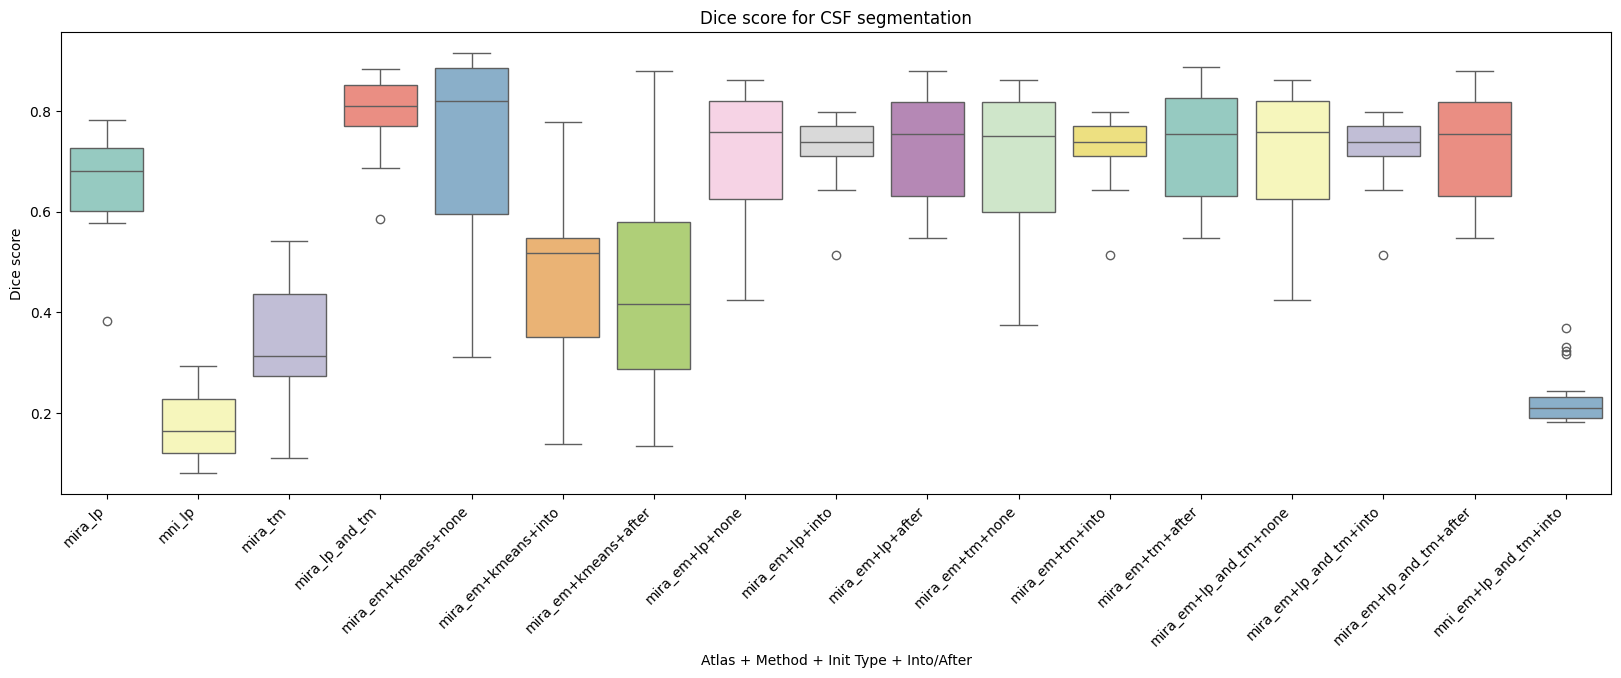

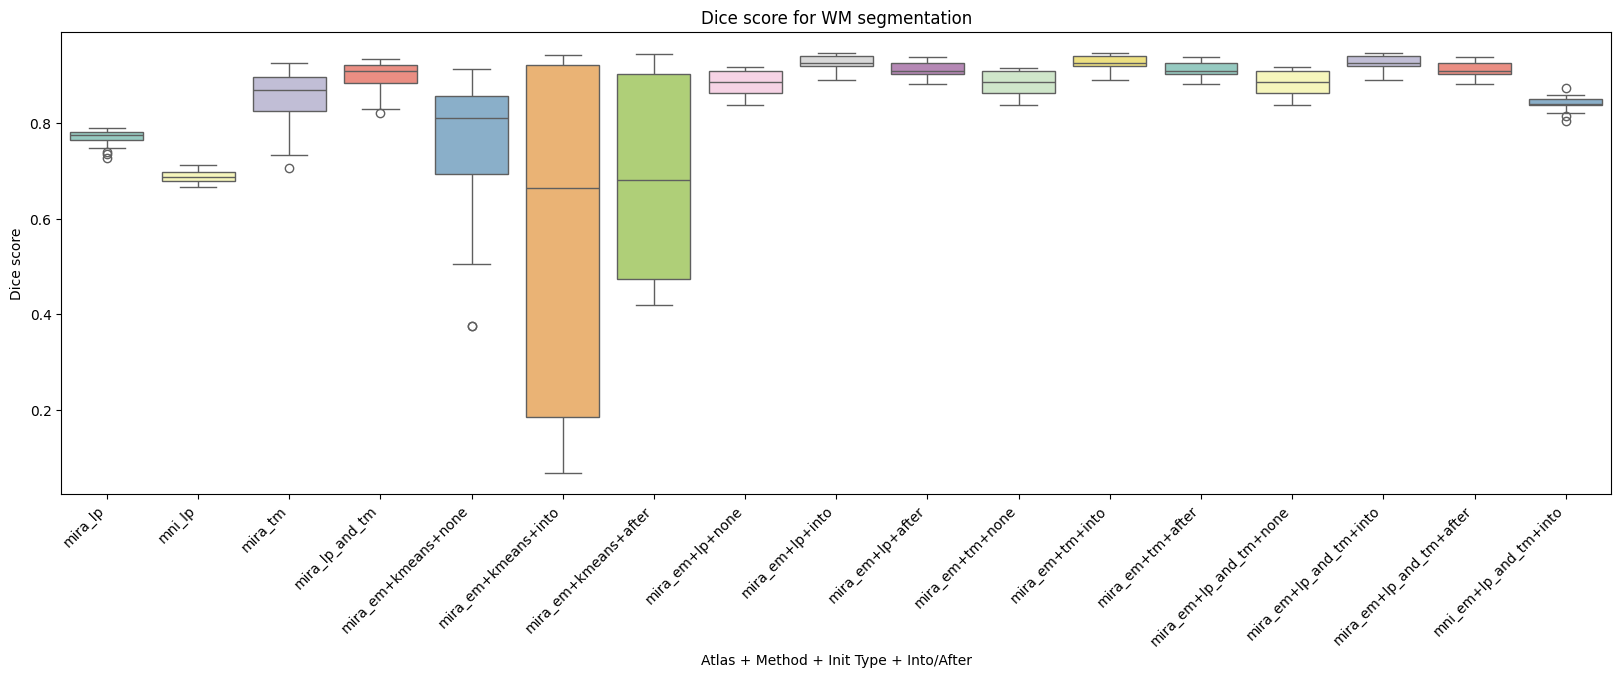

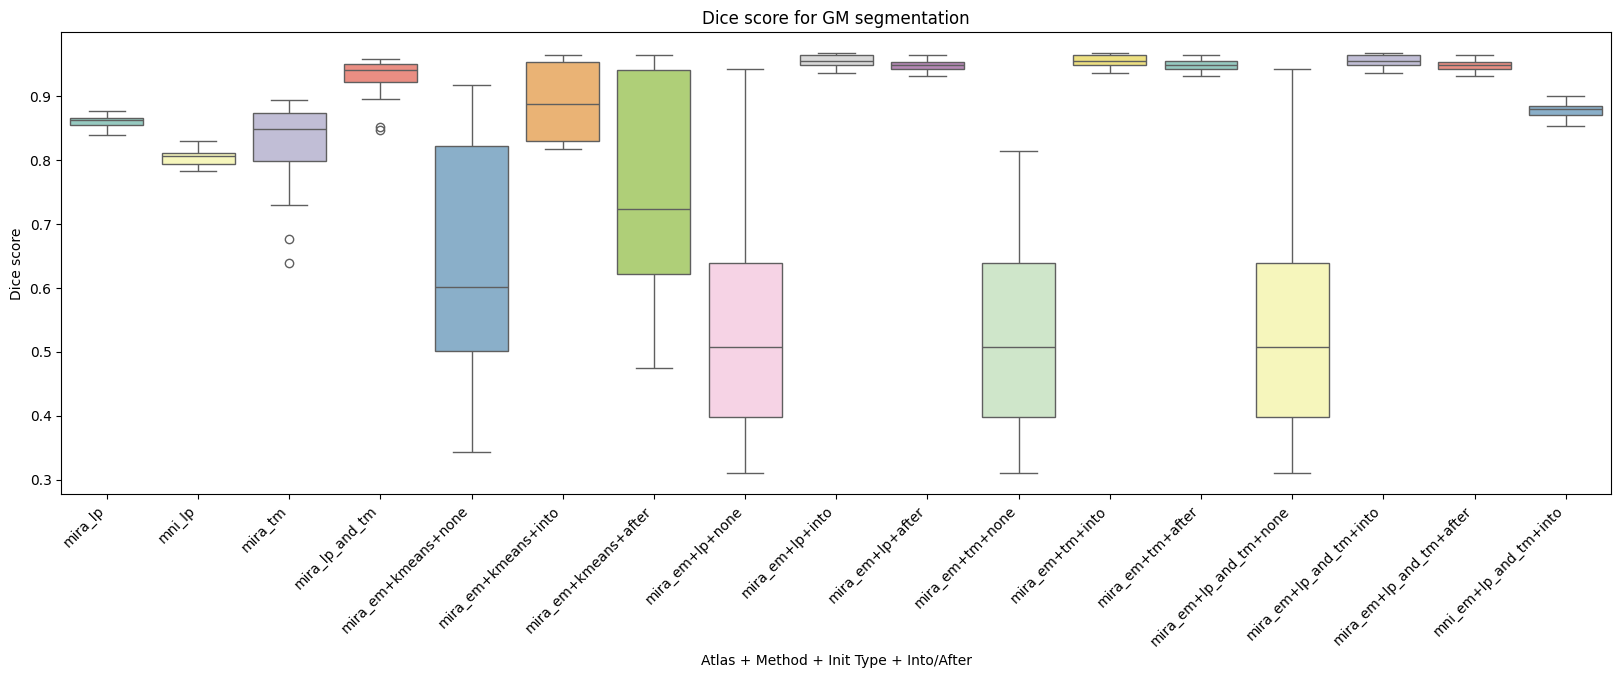

In [6]:
# create a boxplot with atlas+method+init_type+into_or_after for csf, wm, and gm
df.loc[df['method'] == 'em', 'atlas_method_init_into'] = df['atlas'] + '_' + df['method'] + '+' + df['init_type'] + '+' + df['into_or_after']
df.loc[df['method'] != 'em', 'atlas_method_init_into'] = df['atlas'] + '_' + df['method']
    

for score in ['dice_csf', 'dice_wm', 'dice_gm']:
    plt.figure(figsize=(20, 6))
    sns.boxplot(x='atlas_method_init_into', y=score, data=df, palette='Set3', hue='atlas_method_init_into')
    plt.title('Dice score for {} segmentation'.format(score.split('_')[1].upper()))
    plt.xlabel('Atlas + Method + Init Type + Into/After')
    plt.ylabel('Dice score')
    plt.xticks(rotation=45, ha='right')
    plt.show()

### Segmentation without EM

In [7]:
# group by atlas, method, init_type, into_or_after and calculate the mean and stdev of dice scores
methods = ['lp', 'lp_and_tm', 'tm']
filtered_df = df[df['method'].isin(methods)]
filtered_df.groupby(['atlas', 'method', 'init_type', 'into_or_after'])[['dice_csf', 'dice_wm', 'dice_gm']].agg(['mean', 'std'])


dice_csf             dice_wm  \
                                             mean       std      mean   
atlas method    init_type into_or_after                                 
mira  lp        -         -              0.661105  0.091802  0.769132   
      lp_and_tm -         -              0.796505  0.071695  0.898175   
      tm        -         -              0.340959  0.127282  0.852397   
mni   lp        -         -              0.169539  0.061672  0.688850   

                                                    dice_gm            
                                              std      mean       std  
atlas method    init_type into_or_after                                
mira  lp        -         -              0.018490  0.858585  0.010414  
      lp_and_tm -         -              0.032288  0.928293  0.032890  
      tm        -         -              0.061667  0.821551  0.072105  
mni   lp        -         -              0.015140  0.804901  0.012240

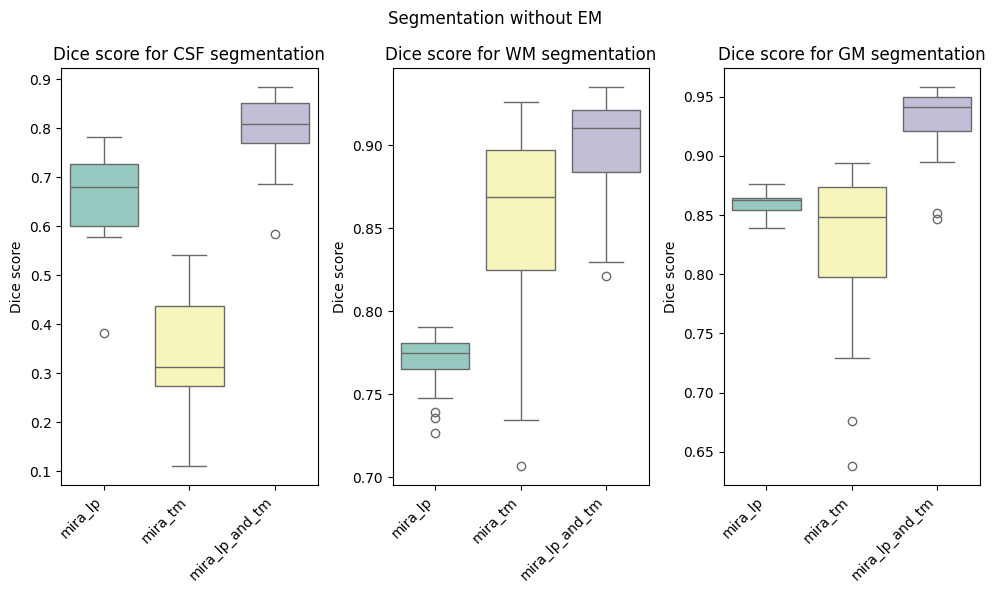

In [8]:
# create a boxplot with atlas+method (for lp, lp_and_tm, tm) for csf, wm, and gm in a single plot

plt.figure(figsize=(10, 6))

# Add a title above all subplots
plt.suptitle('Segmentation without EM')

for i, score in enumerate(['dice_csf', 'dice_wm', 'dice_gm']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='atlas_method_init_into', y=score, data=df[(df['method'] != 'em') & (df['atlas'] == 'mira')], palette='Set3', hue='atlas_method_init_into')
    plt.title('Dice score for {} segmentation'.format(score.split('_')[1].upper()))
    plt.xlabel('')
    plt.ylabel('Dice score')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### EM with different initialization types

In [9]:
# group by atlas, method, init_type, into_or_after and calculate the mean and stdev of dice scores, time, and iterations
methods = ['em']
filtered_df = df[df['method'].isin(methods)]
grouped_df = filtered_df.groupby(['atlas', 'method', 'init_type', 'into_or_after'])[['dice_csf', 'dice_wm', 'dice_gm', 'elapsed_time', 'iter_n']].agg(['mean', 'std'])

# filter results for init_type == 'kmeans', 'lp', or 'tm' and into_or_after == 'none'
filtered_results = grouped_df.loc[(slice(None), slice(None), ['kmeans', 'lp', 'tm'], 'none'), :]
filtered_results


dice_csf             dice_wm            \
                                          mean       std      mean       std   
atlas method init_type into_or_after                                           
mira  em     kmeans    none           0.715660  0.205301  0.746641  0.167730   
             lp        none           0.718764  0.131709  0.884823  0.025631   
             tm        none           0.696641  0.150081  0.884723  0.025495   

                                       dice_gm           elapsed_time  \
                                          mean       std         mean   
atlas method init_type into_or_after                                    
mira  em     kmeans    none           0.641372  0.195628   125.946423   
             lp        none           0.528758  0.164796   139.522510   
             tm        none           0.522308  0.149591   138.221838   

                                                 iter_n             
                                            std    mean        std  
atlas method init_type into_or_after                                
mira  em     kmeans    none           45.326753  126.30  42.597381  
             lp        none           51.008335  150.95  50.636449  
             tm        none           50.004325  146.05  50.974168

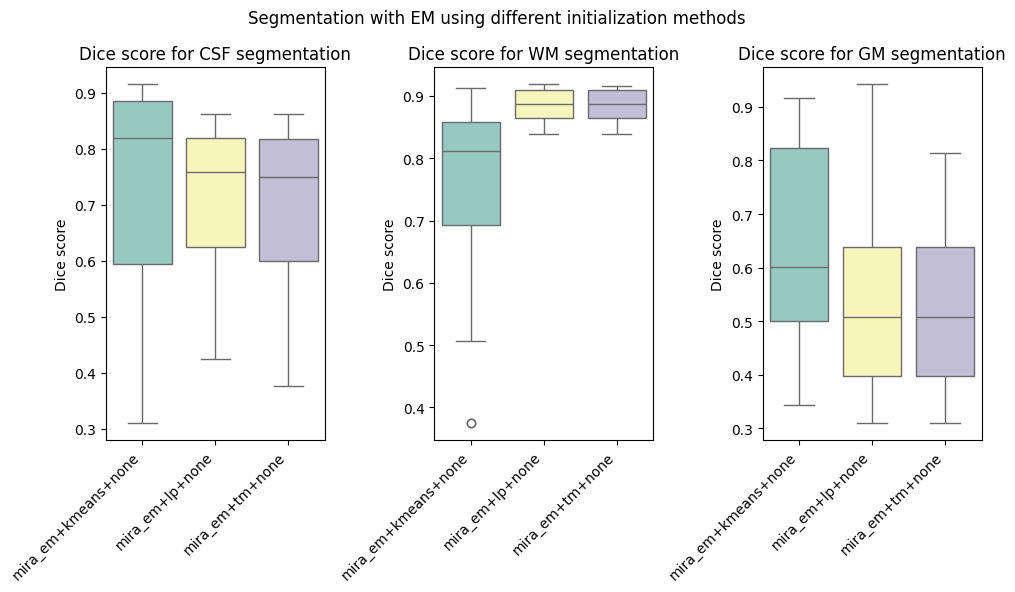

In [10]:
# create a boxplot with atlas+method+init_type+into_or_after for csf, wm, and gm just for em with 'none' into_or_after

plt.figure(figsize=(10, 6))

# Add a title above all subplots
plt.suptitle('Segmentation with EM using different initialization methods')

for i, score in enumerate(['dice_csf', 'dice_wm', 'dice_gm']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='atlas_method_init_into', y=score, data=df[(df['method'] == 'em') & (df['into_or_after'] == 'none') & (df['init_type'] != 'lp_and_tm')], palette='Set3', hue='atlas_method_init_into')
    plt.title('Dice score for {} segmentation'.format(score.split('_')[1].upper()))
    plt.xlabel('')
    plt.ylabel('Dice score')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### EM with MIRA - into/after

In [11]:
# group by atlas, method, init_type, into_or_after and calculate the mean and stdev of dice scores, time, and iterations
methods = ['em']
filtered_df = df[df['method'].isin(methods)]
grouped_df = filtered_df.groupby(['atlas', 'method', 'init_type', 'into_or_after'])[['dice_csf', 'dice_wm', 'dice_gm', 'elapsed_time', 'iter_n']].agg(['mean', 'std'])

# filter results for init_type == 'lp' or 'lp_and_tm' and into_or_after == 'into' or 'after'
filtered_results = grouped_df.loc[(['mira'], slice(None), ['lp', 'lp_and_tm'], ['into', 'after']), :]
filtered_results


dice_csf             dice_wm            \
                                          mean       std      mean       std   
atlas method init_type into_or_after                                           
mira  em     lp        into           0.730082  0.065689  0.927895  0.015292   
                       after          0.727615  0.104697  0.912943  0.015683   
             lp_and_tm into           0.730082  0.065689  0.927895  0.015292   
                       after          0.727615  0.104697  0.912943  0.015683   

                                       dice_gm           elapsed_time  \
                                          mean       std         mean   
atlas method init_type into_or_after                                    
mira  em     lp        into           0.955078  0.009541    64.032151   
                       after          0.948027  0.008603   138.997859   
             lp_and_tm into           0.955078  0.009541    62.826395   
                       after          0.948027  0.008603   137.594030   

                                                 iter_n             
                                            std    mean        std  
atlas method init_type into_or_after                                
mira  em     lp        into           15.292984   49.30   4.508472  
                       after          49.878871  150.95  50.636449  
             lp_and_tm into           14.444814   48.45   4.616618  
                       after          50.248075  149.70  52.271659

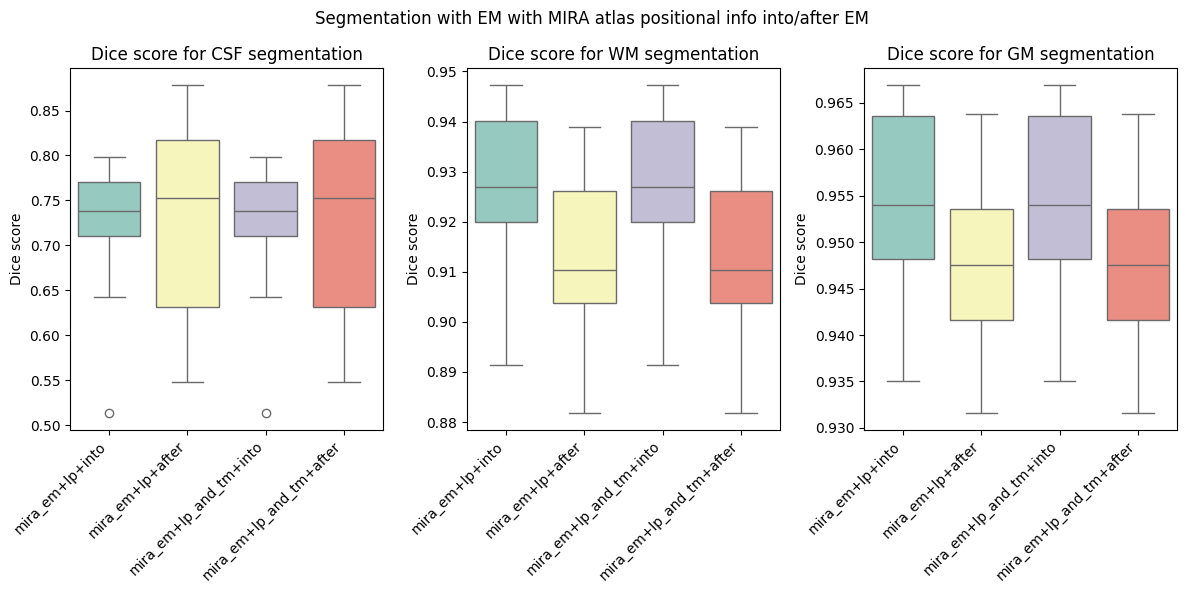

In [13]:
# create a boxplot with atlas+method+init_type+into_or_after for csf, wm, and gm just for em

plt.figure(figsize=(12, 6))

# Add a title above all subplots
plt.suptitle('Segmentation with EM with MIRA atlas positional info into/after EM')

for i, score in enumerate(['dice_csf', 'dice_wm', 'dice_gm']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='atlas_method_init_into', y=score, data=df[(df['method'] == 'em') & (df['into_or_after'] != 'none') & (df['atlas'] == 'mira') & (df['init_type'].isin(['lp', 'lp_and_tm']))], palette='Set3', hue='atlas_method_init_into')
    plt.title('Dice score for {} segmentation'.format(score.split('_')[1].upper()))
    plt.xlabel('')
    plt.ylabel('Dice score')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### EM with MNI - into

In [14]:
# group by atlas, method, init_type, into_or_after and calculate the mean and stdev of dice scores, time, and iterations
methods = ['em']
filtered_df = df[df['method'].isin(methods)]
grouped_df = filtered_df.groupby(['atlas', 'method', 'init_type', 'into_or_after'])[['dice_csf', 'dice_wm', 'dice_gm', 'elapsed_time', 'iter_n']].agg(['mean', 'std'])

# filter results for init_type == 'lp' or 'lp_and_tm' and into_or_after == 'into' or 'after'
filtered_results = grouped_df.loc[(['mira', 'mni'], slice(None), ['lp_and_tm'], ['into']), :]
filtered_results

dice_csf             dice_wm            \
                                          mean       std      mean       std   
atlas method init_type into_or_after                                           
mira  em     lp_and_tm into           0.730082  0.065689  0.927895  0.015292   
mni   em     lp_and_tm into           0.229359  0.057077  0.841592  0.015809   

                                       dice_gm           elapsed_time  \
                                          mean       std         mean   
atlas method init_type into_or_after                                    
mira  em     lp_and_tm into           0.955078  0.009541    62.826395   
mni   em     lp_and_tm into           0.877559  0.012525    58.786894   

                                                iter_n            
                                            std   mean       std  
atlas method init_type into_or_after                              
mira  em     lp_and_tm into           14.444814  48.45  4.616618  
mni   em     lp_and_tm into           11.705417  44.90  5.665222

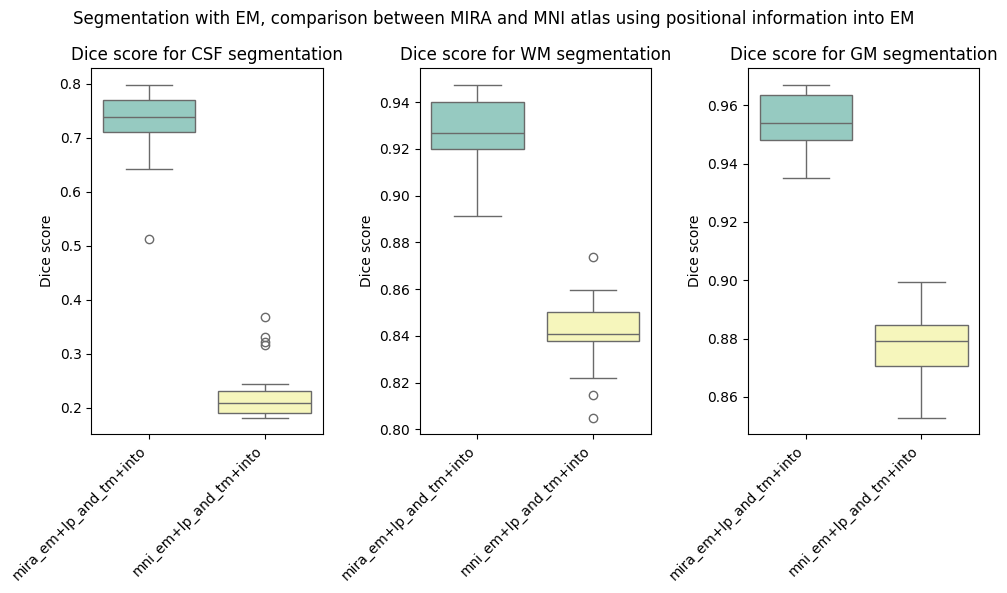

In [20]:
# create a boxplot with atlas+method+init_type+into_or_after for csf, wm, and gm just for em

plt.figure(figsize=(10, 6))

# Add a title above all subplots
plt.suptitle('Segmentation with EM, comparison between MIRA and MNI atlas using positional information into EM')

for i, score in enumerate(['dice_csf', 'dice_wm', 'dice_gm']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='atlas_method_init_into', y=score, data=df[(df['method'] == 'em') & (df['init_type'] == 'lp_and_tm') & (df['into_or_after'] == 'into')], palette='Set3', hue='atlas_method_init_into')
    plt.title('Dice score for {} segmentation'.format(score.split('_')[1].upper()))
    plt.xlabel('')
    plt.ylabel('Dice score')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Determine best atlas for initialization

In [16]:
# group by atlas, method, init_type, into_or_after and calculate the mean and stdev of dice scores, time, and iterations
methods = ['lp']
filtered_df = df[df['method'].isin(methods)]
grouped_df = filtered_df.groupby(['atlas', 'method'])[['dice_csf', 'dice_wm', 'dice_gm']].agg(['mean', 'std'])

# filter results for init_type == 'lp' or 'lp_and_tm' and into_or_after == 'into' or 'after'
filtered_results = grouped_df.loc[(['mira', 'mni'], slice(None), slice(None), slice(None)), :]
filtered_results

dice_csf             dice_wm            dice_gm          
                  mean       std      mean      std      mean       std
atlas method                                                           
mira  lp      0.661105  0.091802  0.769132  0.01849  0.858585  0.010414
mni   lp      0.169539  0.061672  0.688850  0.01514  0.804901  0.012240

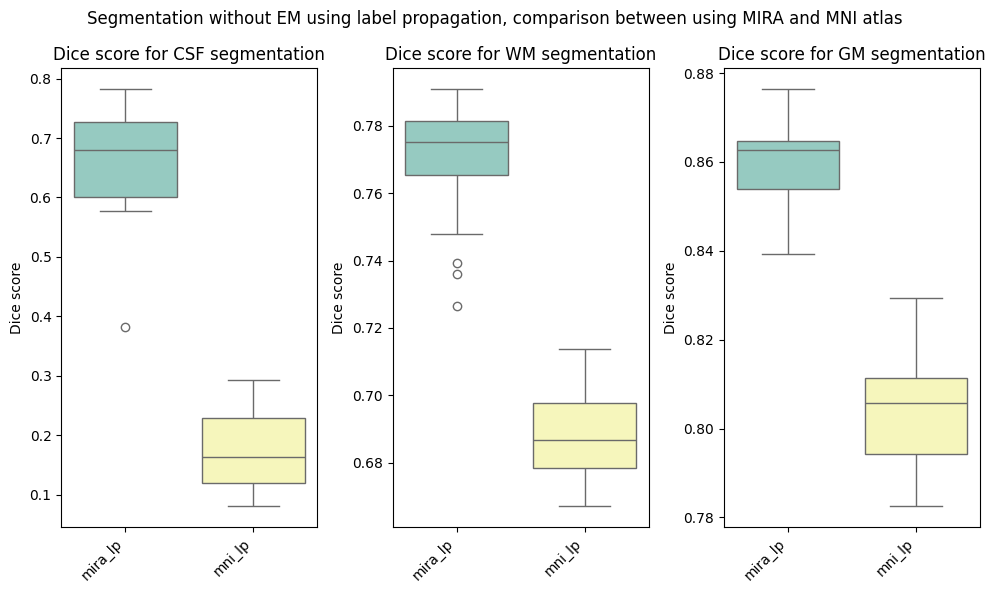

In [24]:
# create a boxplot with atlas+method (for lp, lp_and_tm, tm) for csf, wm, and gm in a single plot

plt.figure(figsize=(10, 6))

# Add a title above all subplots
plt.suptitle('Segmentation without EM using label propagation, comparison between using MIRA and MNI atlas')

for i, score in enumerate(['dice_csf', 'dice_wm', 'dice_gm']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='atlas_method_init_into', y=score, data=df[(df['method'] == 'lp')], palette='Set3', hue='atlas_method_init_into')
    plt.title('Dice score for {} segmentation'.format(score.split('_')[1].upper()))
    plt.xlabel('')
    plt.ylabel('Dice score')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Qualitative results

In [17]:
# load results with labels
df_labels = pd.read_pickle('results/results_labels.pkl.tar.xz', compression='infer')

In [40]:
df_labels.columns

Index(['case_n', 'atlas', 'method', 'labels_em', 'labels_lp', 'labels_tm',
       'labels_lp_and_tm', 'atlas_method_init_into'],
      dtype='object')

In [134]:
cases_to_plot = [df_labels['case_n'].unique()[i] for i in range(4)]

cases_to_plot

['1003', '1004', '1005', '1018']

In [21]:
df_labels.loc[df['method'] == 'em', 'atlas_method_init_into'] = df['atlas'] + '_' + df['method'] + '+' + df['init_type'] + '+' + df['into_or_after']
df_labels.loc[df['method'] != 'em', 'atlas_method_init_into'] = df['atlas'] + '_' + df['method']

In [70]:
# print atlas_method_init_into unique values
df_labels['atlas_method_init_into'].unique()

array(['mira_lp', 'mni_lp', 'mira_tm', 'mira_lp_and_tm',
       'mira_em+kmeans+none', 'mira_em+kmeans+into',
       'mira_em+kmeans+after', 'mira_em+lp+none', 'mira_em+lp+into',
       'mira_em+lp+after', 'mira_em+tm+none', 'mira_em+tm+into',
       'mira_em+tm+after', 'mira_em+lp_and_tm+none',
       'mira_em+lp_and_tm+into', 'mira_em+lp_and_tm+after',
       'mni_em+lp_and_tm+into'], dtype=object)

In [33]:
methods_to_plot = ['mira_lp', 'mira_tm', 'mira_lp_and_tm', 'mira_em+kmeans+none', 'mira_em+tm+none', 'mira_em+lp+none', 'mira_em+lp+into', 'mira_em+lp+after', 'mira_em+lp_and_tm+into', 'mira_em+lp_and_tm+after', 'mni_lp', 'mni_em+lp_and_tm+into']
methods_to_plot

['mira_lp',
 'mira_tm',
 'mira_lp_and_tm',
 'mira_em+kmeans+none',
 'mira_em+tm+none',
 'mira_em+lp+none',
 'mira_em+lp+into',
 'mira_em+lp+after',
 'mira_em+lp_and_tm+into',
 'mira_em+lp_and_tm+after',
 'mni_lp',
 'mni_em+lp_and_tm+into']

In [131]:
# interactive plot with ipywidgets for plot_res

from ipywidgets import interact, fixed

interact(plot_res, slice_n=(0, 255, 1), label_em=fixed(gt[3]), label_gt=fixed(gt[3]))


interactive(children=(IntSlider(value=127, description='slice_n', max=255), Output()), _dom_classes=('widget-i…

<function __main__.plot_res(slice_n, label_em, label_gt)>

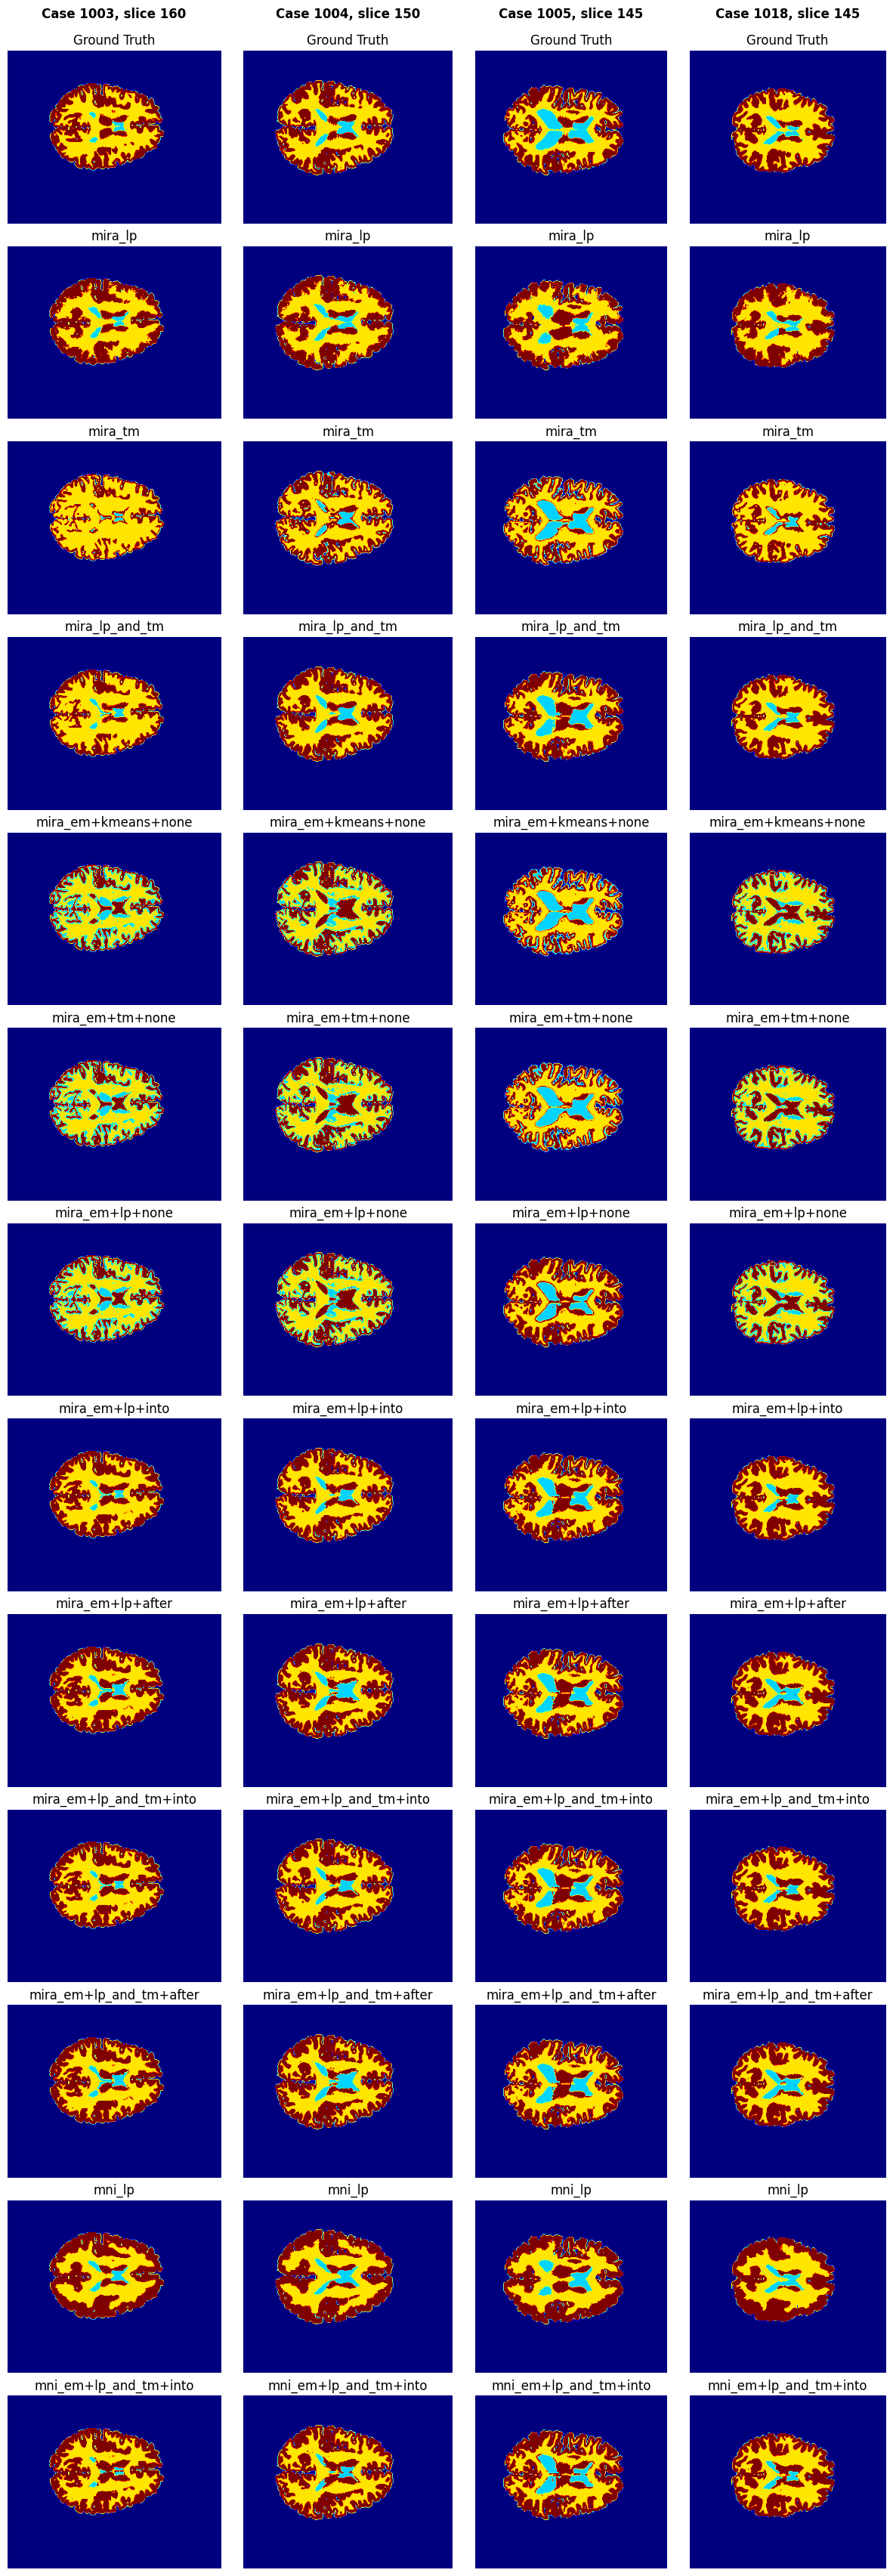

In [135]:
optimal_slices = [160, 150, 145, 145]  # optimal slice numbers for each case

from mpl_toolkits.axes_grid1 import ImageGrid

# create a subplot for each method
fig = plt.figure(figsize=(15, 5*(len(methods_to_plot)+1)))

# create an ImageGrid to align the subplots
grid = ImageGrid(fig, 111, nrows_ncols=(len(methods_to_plot)+1, len(cases_to_plot)), axes_pad=0.3)

# iterate over the methods
for i, method in enumerate(methods_to_plot):
    
    # iterate over the cases
    for j, case in enumerate(cases_to_plot):
        # get the segmentation result for the current case and method
        result = df_labels[(df_labels['case_n'] == case) & (df_labels['atlas_method_init_into'] == method)].iloc[0]

        # get the label to plot
        if '+' in method:
            label = result['labels_em']
        elif 'lp_and_tm' in method:
            label = result['labels_lp_and_tm']
        elif 'lp' in method:
            label = result['labels_lp']
        elif 'tm' in method:
            label = result['labels_tm']
        else:
            raise ValueError(f'Unknown method: {method}')

        # plot the segmentation result if label is available
        if label is not None:
            ax = grid[(i+1) * len(cases_to_plot) + j]
            ax.imshow(label[:, :, optimal_slices[j]], cmap='jet')

        ax.set_title(method)
        ax.axis('off')

# iterate over the cases to display the ground truth in the first row
for j, case in enumerate(cases_to_plot):
    # get the ground truth for the current case
    gt_label = gt[j]
    
    # plot the ground truth if available
    if gt_label is not None:
        ax = grid[j]
        ax.imshow(gt_label[:, :, optimal_slices[j]], cmap='jet')
    
    ax.set_title('Ground Truth')
    ax.axis('off')

    # display the case number at the top of each column with spacing
    ax.text(0.5, 1.1, f'Case {case}, slice {optimal_slices[j]}\n', transform=ax.transAxes, ha='center', fontsize=12, weight='bold')

# adjust the spacing between the subplots
plt.subplots_adjust(top=0.9)

# show the plot
plt.show()
